In [1]:
!pip install git+https://github.com/dtemkin/gsdmm.git
!pip install wordcloud
!pip install --upgrade gensim
!pip install --upgrade s3fs
!pip install --upgrade boto3

  Cloning https://github.com/dtemkin/gsdmm.git to /tmp/pip-req-build-it2_6ndd
  Running command git clone --filter=blob:none --quiet https://github.com/dtemkin/gsdmm.git /tmp/pip-req-build-it2_6ndd
  Resolved https://github.com/dtemkin/gsdmm.git to commit 4cb2d9ef44429229a034d2438c1ef9d5973dcfbb
  Preparing metadata (setup.py) ... done
  Using cached botocore-1.31.64-py3-none-any.whl.metadata (6.1 kB)
Using cached botocore-1.31.64-py3-none-any.whl (11.3 MB)
  Attempting uninstall: botocore
    Found existing installation: botocore 1.33.5
    Uninstalling botocore-1.33.5:
      Successfully uninstalled botocore-1.33.5
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
awscli 1.29.80 requires botocore==1.31.80, but you have botocore 1.31.64 which is incompatible.
awscli 1.29.80 requires s3transfer<0.8.0,>=0.7.0, but you have s3transfer 0.8.2 which is incompatible.
b

In [2]:
import string
import re
import html
import json
import gzip
import datetime
import itertools
import numpy as np
import pandas as pd

from wordcloud import WordCloud

import matplotlib.pyplot as plt

/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/pandas/core/computation/expressions.py:21: UserWarning: Pandas requires version '2.8.0' or newer of 'numexpr' (version '2.7.3' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED


In [3]:
import gensim
from gsdmm import MovieGroupProcess

In [4]:
import nltk

from nltk.stem import WordNetLemmatizer
nltk.download("wordnet")
nltk.download("omw-1.4")

# punctuation
nltk.download("punkt")

# pos tagging
nltk.download('averaged_perceptron_tagger')
nltk.download('tagsets')

from nltk.tokenize import word_tokenize

from nltk.corpus import stopwords 
nltk.download('stopwords')

[nltk_data] Downloading package wordnet to /home/ec2-user/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /home/ec2-user/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package punkt to /home/ec2-user/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /home/ec2-user/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package tagsets to /home/ec2-user/nltk_data...
[nltk_data]   Package tagsets is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /home/ec2-user/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [5]:
# s3 specific libraries
import boto3
s3 = boto3.resource("s3")

import s3fs
s3fs = s3fs.S3FileSystem(anon=False)

In [6]:
english_stop_words = set(stopwords.words('english'))

In [7]:
data_files = [f"s3://{file_path}" for file_path in s3fs.glob("s3://mips-main-tests/chathura_tests/cache2/*cache*.json.gzip")]
len(data_files)

29317

In [8]:
import gsdmm
gsdmm.__file__

'/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/gsdmm/__init__.py'

In [9]:
data_files[0]#[len("s3://mips-main-tests/"):]

's3://mips-main-tests/chathura_tests/cache2/querylist_cache_00_000.json.gzip'

In [10]:
def read_gzip_from_s3(bucket_name, path_inside_bucket):
    obj = s3.Object(bucket_name, path_inside_bucket)
    with gzip.GzipFile(fileobj=obj.get()["Body"]) as gzipfile:
        json_bytes = gzipfile.read()
    return json_bytes

def get_data_from_s3_file(bucket_name, path_inside_bucket):
    json_bytes = read_gzip_from_s3(bucket_name, path_inside_bucket)
    json_str = json_bytes.decode('utf-8')
    data = json.loads(json_str)
    return data

def read_text_data(full_s3_data_file_path):
    len_path_to_bucket = len("s3://mips-main-tests/")
    data = get_data_from_s3_file("mips-main-tests", full_s3_data_file_path[len_path_to_bucket:])
    return data["data"]

In [11]:
np.random.seed(123)
sample_data_files = np.random.choice(data_files, size=100, replace=False)

In [12]:
all_data = list(itertools.chain.from_iterable( [read_text_data(data_file) for data_file in sample_data_files ] ))
len(all_data)

47602

In [13]:
all_data[0]

{'conversation_id': '1507748588167737348',
 'referenced_tweets': [{'type': 'retweeted', 'id': '1507707457761644545'}],
 'edit_history_tweet_ids': ['1507748588167737348'],
 'entities': {'mentions': [{'start': 3,
    'end': 14,
    'username': 'willsommer',
    'id': '274294204'}]},
 'id': '1507748588167737348',
 'public_metrics': {'retweet_count': 448,
  'reply_count': 0,
  'like_count': 0,
  'quote_count': 0,
  'impression_count': 0},
 'created_at': '2022-03-26T15:57:30.000Z',
 'text': "RT @willsommer: Ginni Thomas's election-fraud guru has a history of bizarre statements, including claiming to have arrested the pope.  http…",
 'author_id': '18250847'}

In [14]:
possible_fields = set().union(*[set(tweet.keys()) for tweet in all_data])
possible_fields

{'attachments',
 'author_id',
 'conversation_id',
 'created_at',
 'edit_history_tweet_ids',
 'entities',
 'geo',
 'id',
 'in_reply_to_user_id',
 'public_metrics',
 'referenced_tweets',
 'text',
 'withheld'}

In [15]:
common_fields = possible_fields.intersection(*[set(tweet.keys()) for tweet in all_data])
common_fields

{'author_id',
 'conversation_id',
 'created_at',
 'edit_history_tweet_ids',
 'id',
 'public_metrics',
 'text'}

In [16]:
class Maybe:
    def __init__(self, json_object):
        self.json_object = json_object
        
    def field(self, field):
        if self.json_object is not None and type(self.json_object) is dict and field in self.json_object:
            return Maybe(self.json_object[field])
        return Maybe(None)
    
    def index(self, index):
        if self.json_object is not None and type(self.json_object) is list and index < len(self.json_object):
            return Maybe(self.json_object[index])
        return Maybe(None)
    
    def array(self, func=lambda m: m, as_type=list):
        if self.json_object is not None and type(self.json_object) is list:
            return as_type([func(obj) for obj in self.json_object])
        return []
    
    def value(self):
        return self.json_object

# get_maybe(get_maybe(tweet_json, "referenced_tweets"), "quoted")

In [17]:
column_names = ['id',
                'conversation_id',
                'edit_history_tweet_ids',
                'author_id',
                'created_at',
                'text',
                'impression_count',
                'like_count',
                'quote_count',
                'reply_count',
                'retweet_count',
                'quoted',
                'replied_to',
                'retweeted',
                'in_reply_to_user_id',
                'mentions']
def get_columns(tweet_json):
    quoted = []
    replied_to = []
    retweeted = []
    for ref_tweet in Maybe(tweet_json).field("referenced_tweets").array():
        if ref_tweet["type"] == "quoted":
            quoted.append(ref_tweet["id"])
        elif ref_tweet["type"] == "replied_to":
            replied_to.append(ref_tweet["id"])
        elif ref_tweet["type"] == "retweeted":
            retweeted.append(ref_tweet["id"])
    columns_values = [
        # tweet always has following keys
        tweet_json["id"],
        tweet_json["conversation_id"],
        tweet_json["edit_history_tweet_ids"], # list of tweetIds
        tweet_json["author_id"],
        tweet_json["created_at"],
        tweet_json["text"],
        tweet_json["public_metrics"]["impression_count"],
        tweet_json["public_metrics"]["like_count"],
        tweet_json["public_metrics"]["quote_count"],
        tweet_json["public_metrics"]["reply_count"],
        tweet_json["public_metrics"]["retweet_count"],
        # optional tweet data fields
        str(quoted),
        str(replied_to),
        str(retweeted),
        Maybe(tweet_json).field("in_reply_to_user_id").value(),
        # tweet_json["geo"] # we dont take this field at the moment
        Maybe(tweet_json).field("entities").field("mentions").array(lambda m: m["id"], str),
        # Maybe(tweet_json).field("attachments") # we dont take this field at the moment
    ]
    return columns_values


In [35]:
df = pd.DataFrame([get_columns(d) for d in all_data], columns=column_names)
df

,id,conversation_id,edit_history_tweet_ids,author_id,created_at,text,impression_count,like_count,quote_count,reply_count,retweet_count,quoted,replied_to,retweeted,in_reply_to_user_id,mentions
0,1507748588167737348,1507748588167737348,[1507748588167737348],18250847,2022-03-26T15:57:30.000Z,RT @willsommer: Ginni Thomas's election-fraud ...,0,0,0,0,448,[],[],['1507707457761644545'],None,['274294204']
1,1507747586035396609,1507747586035396609,[1507747586035396609],1240497218,2022-03-26T15:53:31.000Z,RT @SharonSalzberg: Today's inspiration by Eli...,0,0,0,0,51,[],[],['1507658775381135367'],None,['15977916']
2,1507747550094401539,1507747550094401539,[1507747550094401539],1240497218,2022-03-26T15:53:23.000Z,Must read! \n\nHillary Clinton: Madeleine Albr...,0,1,0,0,0,[],[],[],None,[]
3,1507746870231138309,1507746345263714304,[1507746870231138309],1663761480,2022-03-26T15:50:41.000Z,@DanielaPopelka 😂,0,2,0,0,0,[],['1507746345263714304'],[],1492299326948884482,['1492299326948884482']
4,1507746745836396547,1507746745836396547,[1507746745836396547],18250847,2022-03-26T15:50:11.000Z,RT @Stonekettle: Thread,0,0,0,0,26,[],[],['1507723155225419787'],None,['41223126']
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
47597,1498828993105170435,1498828993105170435,[1498828993105170435],1016486686958739457,2022-03-02T01:14:13.000Z,RT @MuellerSheWrote: Does this include @Tucker...,0,0,0,0,169,[],[],['1498828593257799686'],None,"['926164634570067968', '22703645']"
47598,1498828969323417608,1498828969323417608,[1498828969323417608],1199852955949785088,2022-03-02T01:14:07.000Z,RT @DineshDSouza: My family spent a delightful...,0,0,0,0,306,[],[],['1498825815324336132'],None,"['91882544', '844281463', '34916539']"
47599,1498828961295568898,1498828961295568898,[1498828961295568898],1016486686958739457,2022-03-02T01:14:05.000Z,RT @BryanDawsonUSA: Joe Biden has already redu...,0,0,0,0,273,[],[],['1498825279598432260'],None,['997682274']
47600,1498828882488840198,1498828882488840198,[1498828882488840198],1016486686958739457,2022-03-02T01:13:47.000Z,RT @TheRickWilson: Most of their jets are park...,0,0,0,0,179,[],[],['1498828666477977603'],None,['19084896']


In [36]:
# df = pd.read_csv("s3://mips-main-tests/chathura_tests/data_minimal/all_data_minimal.csv")
# df

In [37]:
# df[df["created_at"] == '2022-04-01T04:58:38.000Z']

In [38]:
results = []
for tweet_text in df.text.values:
    result = tweet_text
    result = re.sub(r"(@\S+|http\S+|\n|\'|[“”’])", "", result)
    result = re.sub("^RT\s", "", result)
    result = html.unescape(result)
    results.append(result)

In [39]:
results

[' Ginni Thomass election-fraud guru has a history of bizarre statements, including claiming to have arrested the pope.  ',
 ' Todays inspiration by Eliza Todd ',
 'Must read! Hillary Clinton: Madeleine Albright Warned Us, and She Was Right ',
 ' 😂',
 ' Thread',
 ' In his defense, it probably sounded like a great idea after a couple lines of blow.',
 ' Hey look! The GOP got to build a pipeline...',
 ' What my friends ?#photos #photography #animals #puma ',
 ' 🌿Au déclin du jour     Pour rester dans le printemps      Ma robe à fleurs Haïku (Haruyo Morita) ',
 '  Brilliant!!! Thanks for sharing.',
 ' Strange coincidence.',
 ' "When we are no longer able to change a situation, we are challenged to change ourselves.(Viktor Frankl)',
 ' This is some shady humor',
 ' Know that the greatest service that man can offer to God is to help convert souls. St. Rose of Lima ',
 ' This turned out to be Dielis plumipes, i.e. the Feather-legged Scoliid WaspFearsome looking, but theyre nonaggressive a…',

In [40]:
# Initialize wordnet lemmatizer
wnl = WordNetLemmatizer()

def postag_to_argument(postag):
    if postag[0] == "V":
        return "v"
    elif postag[0] == "N":
        return "n"
    elif postag[0] == "J":
        return "a"
    elif postag[0] == "R":
        return "r"
    else:
        return "v"

def get_words(in_sentence, in_wnlemmatizer):
    # print(in_sentence)
    # Remove punctuation
    example_sentence_no_punct = in_sentence.translate(str.maketrans("", "", string.punctuation))
    # print(example_sentence_no_punct)
    # separate tokens
    word_tokens = word_tokenize(example_sentence_no_punct)
    # print(word_tokens)
    # tag Part of Speech
    postag = dict(nltk.pos_tag(word_tokens))
    # print(postag)
    # Lemmatize
    lemmas = [ wnl.lemmatize(word, pos=postag_to_argument(postag[word])) for word in word_tokens ]
    # print(lemmas)
    # remove stop words
    filtered_lemmas = [w for w in lemmas if not w.lower() in english_stop_words]
    # print(filtered_word_tokens)
    return filtered_lemmas

In [41]:
text_tokens = [ get_words(doc, wnl) for doc in results ]
text_tokens

[['Ginni',
  'Thomass',
  'electionfraud',
  'guru',
  'history',
  'bizarre',
  'statement',
  'include',
  'claim',
  'arrest',
  'pope'],
 ['Todays', 'inspiration', 'Eliza', 'Todd'],
 ['Must',
  'read',
  'Hillary',
  'Clinton',
  'Madeleine',
  'Albright',
  'Warned',
  'Us',
  'Right'],
 ['😂'],
 ['Thread'],
 ['defense',
  'probably',
  'sound',
  'like',
  'great',
  'idea',
  'couple',
  'line',
  'blow'],
 ['Hey', 'look', 'GOP', 'get', 'build', 'pipeline'],
 ['friend', 'photos', 'photography', 'animal', 'puma'],
 ['🌿Au',
  'déclin',
  'du',
  'jour',
  'Pour',
  'rester',
  'dans',
  'le',
  'printemps',
  'robe',
  'à',
  'fleurs',
  'Haïku',
  'Haruyo',
  'Morita'],
 ['Brilliant', 'Thanks', 'share'],
 ['Strange', 'coincidence'],
 ['longer',
  'able',
  'change',
  'situation',
  'challenge',
  'change',
  'ourselvesViktor',
  'Frankl'],
 ['shady', 'humor'],
 ['Know',
  'great',
  'service',
  'man',
  'offer',
  'God',
  'help',
  'convert',
  'souls',
  'St',
  'Rose',
  'Lim

In [42]:
# create dictionary of all words in all documents
dictionary = gensim.corpora.Dictionary(text_tokens)

# filter extreme cases out of dictionary
dictionary.filter_extremes(no_below=15, no_above=0.5, keep_n=100000)

# create variable containing length of dictionary/vocab
vocab_length = len(dictionary)

# create BOW dictionary
bow_corpus = [dictionary.doc2bow(doc) for doc in text_tokens]

# initialize GSDMM
gsdmm = MovieGroupProcess(K=10, alpha=0.1, beta=0.3, n_iters=15)

# fit GSDMM model
y = gsdmm.fit(text_tokens, vocab_length)

In stage 0: transferred 39218 clusters with 10 clusters populated
In stage 1: transferred 29106 clusters with 10 clusters populated
In stage 2: transferred 24548 clusters with 10 clusters populated
In stage 3: transferred 20111 clusters with 10 clusters populated
In stage 4: transferred 16547 clusters with 10 clusters populated
In stage 5: transferred 15170 clusters with 10 clusters populated
In stage 6: transferred 14160 clusters with 10 clusters populated
In stage 7: transferred 13968 clusters with 10 clusters populated
In stage 8: transferred 13562 clusters with 10 clusters populated
In stage 9: transferred 13314 clusters with 10 clusters populated
In stage 10: transferred 13079 clusters with 10 clusters populated
In stage 11: transferred 13002 clusters with 10 clusters populated
In stage 12: transferred 12947 clusters with 10 clusters populated
In stage 13: transferred 12682 clusters with 10 clusters populated
In stage 14: transferred 12677 clusters with 10 clusters populated


In [43]:
# print number of documents per topic
doc_count = np.array(gsdmm.cluster_doc_count)
print('Number of documents per topic :', doc_count)

# Topics sorted by the number of document they are allocated to
top_index = doc_count.argsort()[-15:][::-1]
print('Most important clusters (by number of text_tokens inside):', top_index)

# define function to get top words per topic
def top_words(cluster_word_distribution, top_cluster, values):
    for cluster in top_cluster:
        sort_dicts = sorted(cluster_word_distribution[cluster].items(), key=lambda k: k[1], reverse=True)[:values]
        print("\nCluster %s : %s"%(cluster, sort_dicts))

# get top words in topics
top_words(gsdmm.cluster_word_distribution, top_index, 20)

Number of documents per topic : [5232 5499 3692 6070 4080 3844 3420 4851 2485 8429]
Most important clusters (by number of text_tokens inside): [9 3 1 0 7 4 5 2 6 8]

Cluster 9 : [('get', 845), ('like', 631), ('go', 602), ('Im', 582), ('know', 529), ('people', 519), ('dont', 468), ('one', 437), ('think', 433), ('make', 427), ('say', 415), ('see', 405), ('want', 380), ('time', 343), ('good', 326), ('thing', 297), ('year', 287), ('need', 279), ('would', 279), ('take', 263)]

Cluster 3 : [('vote', 347), ('say', 345), ('right', 343), ('Biden', 332), ('Trump', 268), ('people', 264), ('Republicans', 250), ('would', 225), ('get', 221), ('year', 217), ('make', 215), ('state', 203), ('one', 202), ('GOP', 198), ('President', 196), ('want', 195), ('go', 194), ('bill', 191), ('need', 183), ('Republican', 180)]

Cluster 1 : [('Ukraine', 1025), ('Russian', 833), ('Russia', 646), ('Putin', 530), ('say', 446), ('US', 426), ('war', 331), ('Ukrainian', 327), ('President', 322), ('Biden', 306), ('Trump', 

In [47]:
def draw_wordcloud(topic_number, values = 20):
    # Get topic word distributions from gsdmm model
    cluster_word_distribution = gsdmm.cluster_word_distribution
    
    # Select topic you want to output as dictionary (using topic_number)
    topic_dict = sorted(cluster_word_distribution[topic_number].items(), key=lambda k: k[1], reverse=True)
    
    # Generate a word cloud image
    wc = WordCloud(background_color='#fcf2ed', 
                                width=1800,
                                height=700,
                                random_state = 123,
                                font_path="Symbola.otf",
                                colormap='flag')
    
    wc.generate_from_frequencies(dict(topic_dict[:values]))

    print(topic_number, topic_dict[:values])
    
    # Print to screen
    fig, ax = plt.subplots(figsize=[10,10])
    plt.imshow(wc, interpolation='bilinear')
    plt.axis("off")
    
    # Save to disk
    wc.to_file(f"./wc_{topic_number}.png")
    
    plt.show()

9 [('get', 845), ('like', 631), ('go', 602), ('Im', 582), ('know', 529), ('people', 519), ('dont', 468), ('one', 437), ('think', 433), ('make', 427), ('say', 415), ('see', 405), ('want', 380), ('time', 343), ('good', 326), ('thing', 297), ('year', 287), ('need', 279), ('would', 279), ('take', 263), ('look', 236), ('day', 233), ('work', 231), ('come', 220), ('love', 220)]


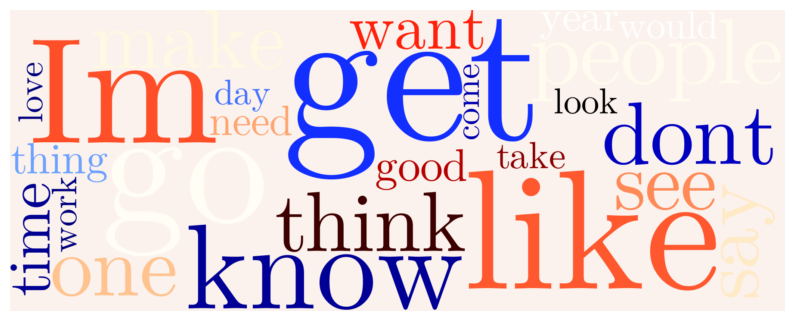

3 [('vote', 347), ('say', 345), ('right', 343), ('Biden', 332), ('Trump', 268), ('people', 264), ('Republicans', 250), ('would', 225), ('get', 221), ('year', 217), ('make', 215), ('state', 203), ('one', 202), ('GOP', 198), ('President', 196), ('want', 195), ('go', 194), ('bill', 191), ('need', 183), ('Republican', 180), ('support', 175), ('know', 174), ('think', 172), ('like', 166), ('election', 166)]


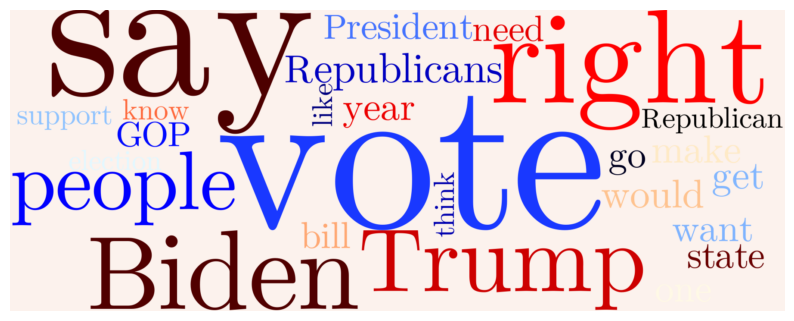

1 [('Ukraine', 1025), ('Russian', 833), ('Russia', 646), ('Putin', 530), ('say', 446), ('US', 426), ('war', 331), ('Ukrainian', 327), ('President', 322), ('Biden', 306), ('Trump', 254), ('people', 242), ('call', 188), ('military', 185), ('Russias', 183), ('go', 167), ('BREAKING', 167), ('Putins', 148), ('NATO', 147), ('invasion', 144), ('one', 143), ('Kyiv', 142), ('force', 142), ('world', 139), ('take', 133)]


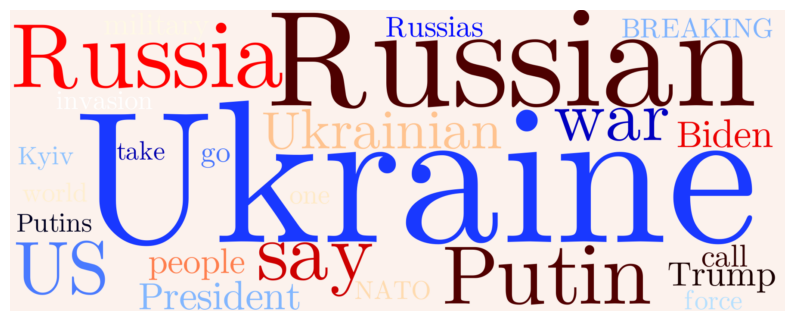

0 [('Happy', 280), ('Good', 212), ('new', 189), ('day', 184), ('NowPlaying', 178), ('New', 175), ('morning', 168), ('Listen', 125), ('today', 123), ('year', 121), ('Day', 118), ('Christmas', 116), ('Thank', 115), ('love', 113), ('online', 111), ('book', 108), ('Im', 104), ('song', 103), ('friend', 101), ('Love', 98), ('everyone', 97), ('get', 96), ('time', 89), ('Year', 83), ('birthday', 78)]


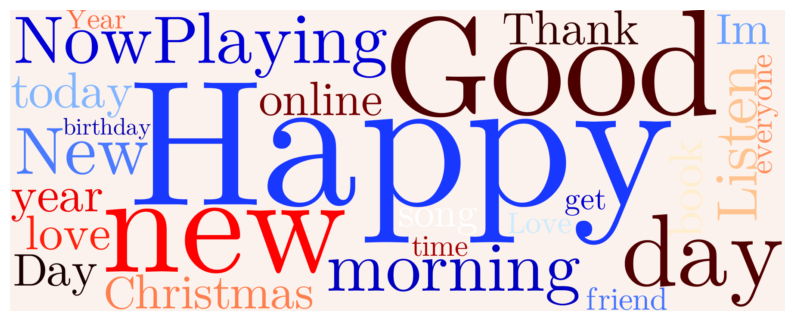

7 [('year', 279), ('new', 241), ('people', 224), ('COVID19', 208), ('get', 198), ('work', 191), ('climate', 188), ('make', 180), ('COVID', 174), ('US', 172), ('help', 168), ('say', 166), ('test', 162), ('one', 160), ('change', 153), ('time', 142), ('million', 138), ('mask', 138), ('job', 135), ('price', 133), ('report', 132), ('week', 129), ('case', 128), ('use', 128), ('need', 127)]


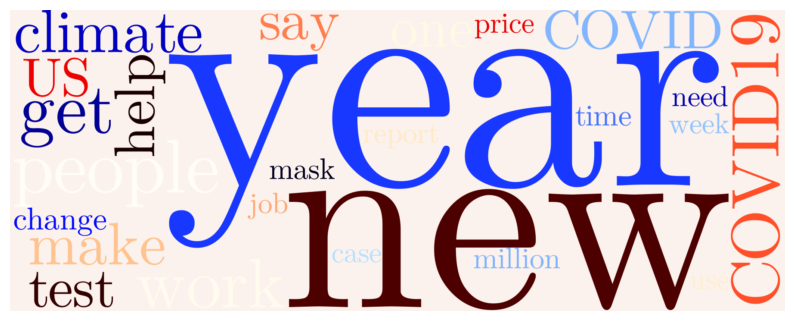

4 [('make', 174), ('one', 133), ('love', 124), ('get', 124), ('like', 112), ('say', 100), ('life', 96), ('would', 95), ('God', 91), ('time', 89), ('world', 85), ('use', 84), ('think', 83), ('see', 83), ('need', 83), ('go', 81), ('take', 80), ('ClimateAction', 79), ('come', 76), ('know', 76), ('good', 75), ('way', 71), ('us', 71), ('look', 69), ('help', 67)]


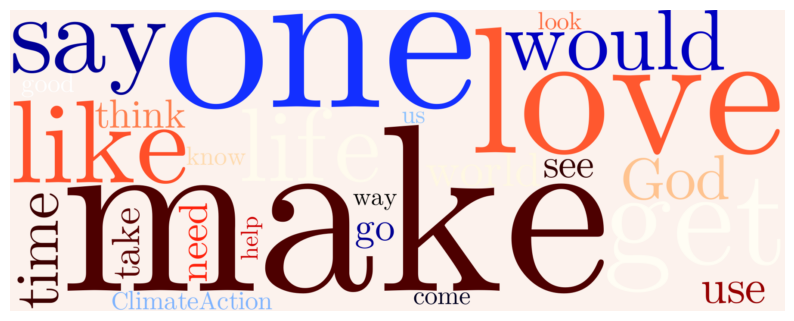

5 [('Trump', 364), ('6', 260), ('Jan', 237), ('say', 159), ('New', 144), ('via', 136), ('January', 110), ('BREAKING', 106), ('‘', 96), ('House', 96), ('Trumps', 93), ('US', 91), ('Capitol', 84), ('Judge', 83), ('Jackson', 81), ('new', 76), ('committee', 73), ('indiemusic', 71), ('kbradiothp', 70), ('internetradio', 70), ('Donald', 66), ('York', 65), ('2022', 64), ('get', 62), ('White', 62)]


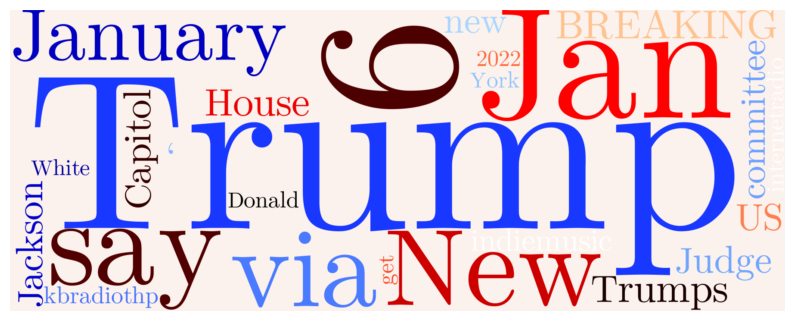

2 [('year', 178), ('say', 157), ('kill', 140), ('police', 138), ('one', 118), ('get', 117), ('today', 98), ('man', 97), ('go', 95), ('people', 94), ('officer', 91), ('woman', 91), ('child', 87), ('King', 85), ('first', 85), ('2', 83), ('day', 82), ('family', 81), ('shoot', 81), ('honor', 79), ('US', 77), ('Police', 76), ('take', 76), ('arrest', 76), ('two', 75)]


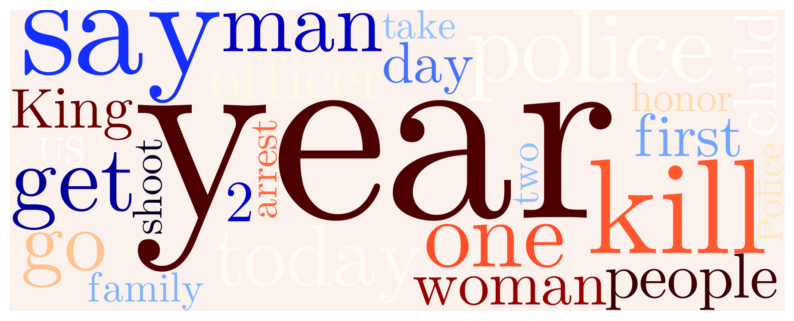

6 [('snow', 216), ('today', 155), ('area', 144), ('day', 139), ('fire', 138), ('wind', 127), ('storm', 127), ('across', 119), ('near', 113), ('PM', 112), ('County', 108), ('see', 106), ('weather', 105), ('morning', 101), ('get', 90), ('continue', 88), ('tornado', 86), ('look', 84), ('close', 83), ('rain', 82), ('like', 81), ('cold', 76), ('week', 74), ('time', 74), ('low', 74)]


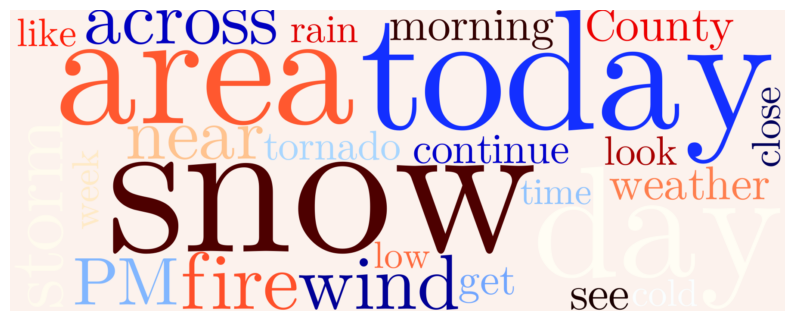

8 [('de', 253), ('via', 206), ('Learning', 129), ('Machine', 126), ('la', 118), ('en', 84), ('etsymntt', 66), ('el', 65), ('Knit', 62), ('Hand', 61), ('Check', 57), ('que', 55), ('Scarf', 52), ('del', 43), ('에릭남', 41), ('Vintage', 41), ('EricNamTABA', 40), ('handmade', 40), ('AI', 38), ('los', 37), ('e', 36), ('un', 36), ('HearYourselfBook', 36), ('ThereAndBackAgain', 35), ('w', 34)]


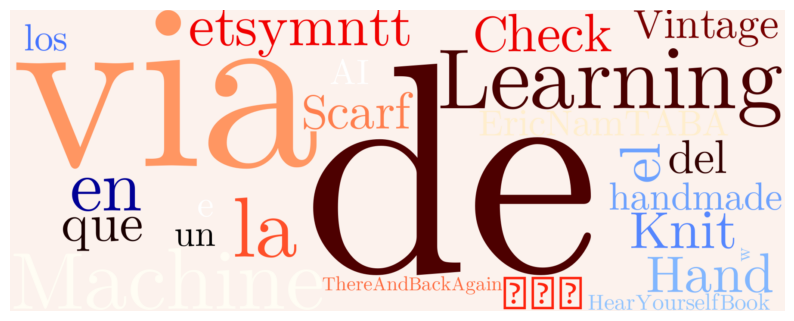

In [48]:
for cluster in top_index:
    draw_wordcloud(cluster, 25)